# A Tutorial on Noise-Free Gaussian Process Regression
## *Theory and Practice*
***

#### By Jerry Jeyachandra [(github)](https://www.github.com/jerdra)
##### Sourced from Rasmussen & Williams (2006)
***

This is a tutorial on **Gaussian Process $(\mathcal{GP})$ Regression** in the **Noise-free** setting (observations provide perfect information) 

This is the context in which **Bayesian Optimization** is performed, that is, we have some underlying function that we don't have access to entirely and can only learn about by sampling points. With **Bayesian Optimization** we want to optimally select points as to learn as much as we can about the underlying function without sampling too often; each evaluation of the true objective function is expensive. 

**$\mathcal{GP}$ Regression** allows us to model the model parameter space probabilistically, giving us a framework to explore our model space with some assumptions of underlying structure.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial.distance import pdist, squareform #pairwise distance; convert upper triangular to square

In [2]:
#This is the true function we want to model with our gaussian process regression 
#Yes, it's ugly, and you'd never guess from just looking at it, but that's the point
def true_func(x):
    return 0.1*((8*np.exp(-0.0125*x))*np.sin(x*0.25) + 0.055*x + 50*np.exp(-10/(1+0.25*x)) -
                0.005*(x-50)**2)  - 1.5

## Rationale behind Gaussian Process
Suppose we had some unknown function that we wanted to extract some interesting information about - for example estimating a maxima, or gaining an estimate of what it might look and behave like for error tolerance measures etc... 

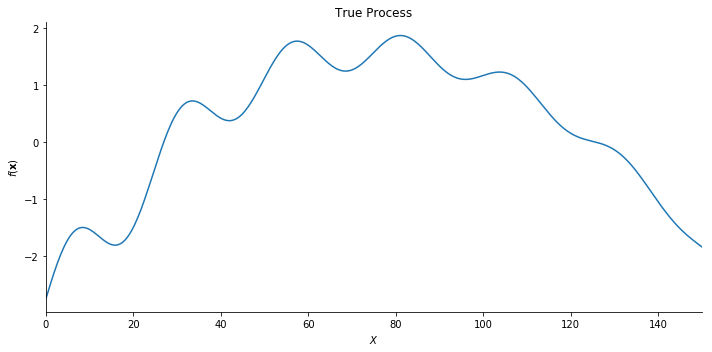

In [3]:
#Generate the true underlying objective function we want to learn about
x = np.linspace(0,150,400)
x = x.reshape((x.shape[0],1)) #column vector of samples
y = true_func(x)

## Visualize
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(111)
ax.plot(x,y)
ax.set_xlabel(r'$X$')
ax.set_ylabel(r'$f(\mathbf{x})$')
ax.set_title('True Process')
ax.set_xlim(0,150)

plt.tight_layout()

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.savefig('./figures/true_func.png')
plt.show()

***
# Gaussian Processes


$\mathcal{GP}$ regression is a Bayesian regression technique that non-parameterically models stochastic processes. Importantly, $\mathcal{GP}$'s model the phenomena of interest probabilistically using *distributions over functions* rather than over *parameters*. While there is some underlying duality here between the **function-space view** of $\mathcal{GP}$ and the traditional **weight-space view** of standard bayesian regression, $\mathcal{GP}$'s are far more flexible and elegant to work with. 

The main idea is to use **covariance kernel functions** in order to imbue loose beliefs (structural assumptions) about the behaviour of the data into our regression model. The beauty of the bayesian side of this model is that we can update our beliefs about the data via **Bayes Theorem** which allows us to integrate evidence (observations) as they come in. 

***

### Definition

Formally, a $\mathcal{GP}$ is a collection random variables in which any finite subset have a **joint Gaussian Distribution**. This implies a property of **consistency**, in that any subset $y$ containing any finite subset of $\mathcal{GP}$ is a multivariate gaussian variable. For example, suppose there are two subsets such that the $\mathcal{GP}$ specifies that:

$$(y_1,y_2) \sim \mathcal{N}(\mathbf{0},\Sigma)$$
Then it must also be true that:
$$y_1 \sim \mathcal{N}(\mathbf{0},\Sigma_{11})$$
Where $\Sigma_{11}$ is a block submatrix from $\Sigma$ corresponding to $y_1$. Note that while $\mathcal{GP}$ is technically infinite-dimensional (it's continuous!), any *finite subset is a multivariate gaussian distribution* - which is an extremely useful property!.


### Specification of $\mathcal{GP}$



The $\mathcal{GP}$ can be fully specified with two components, the **mean function** and the **covariance function**:

$$m(\mathbf{x}) = \mathbb{E}\left[ f(\mathbf{x}) \right]$$
$$k(\mathbf{x}_i,\mathbf{x}_j) = \mathbb{E}\left[ (f(\mathbf{x}_i) - m(\mathbf{x}) ) (f(\mathbf{x}_j) - m(\mathbf{x}) ) \right]$$

We represent the distribution that we believe that our data is drawn from as follows:

$$f(\mathbf{x}) \sim \mathcal{GP}(m(\mathbf{x}), k(\mathbf{x}_i,\mathbf{x}_j))$$


Note that the function $f(\mathbf{x})$ is drawn from a probability distribution $\mathcal{GP}$, thus we're dealing with probabilistic functions - $\mathcal{GP}$ is a *distribution over functions*!

Since we're working within a Bayesian framework, we need to specify a prior which reflects our beliefs about the data.

## Specifying our prior

### Mean Function

We begin by making no assumptions about the underlying model's mean behaviour. That is to say, we start with an *uninformed prior*:

$$m(\mathbf{x}) = \mathbf{0}$$

*One could make the argument that the $\mathbf{0}$ function is informed since we assume that our input $X$ is linearly related to our output (which it's not), but that's another discussion that's outside the scope of this tutorial...*

We could be a little bit more informed if we knew something about the underlying function that we're dealing with - but in this case we have no idea since we haven't observed any data at this point. An alternative method would be to first randomly sample the data (or at regular intervals) to build a starting mean function but this will turn out to happen anyway once we start integrating observations into our uninformed prior. 

### Covariance Function

The **covariance function** is where most of the *art/domain knowledge* behind $\mathcal{GP}$ begins. The covariance function is a *statement about what you believe the function you're modelling behaves like*. In the example of noise-free observations it encodes rather simple beliefs; but in the noisy observation setting it becomes an important part of the regression model. Since we know *literally nothing* about the underlying function, we'll make a reasonable assumption that the underlying data is *smooth*. To encode this mathematically we use the **Squared Exponential Distance Function**. 

#### Squared Exponential Distance Function

$$\text{RBF}(\mathbf{x}_i,\mathbf{x}_j) = \exp \left( 
    -\frac{1}{2l^2}\|\mathbf{x}_i - \mathbf{x}_j \|
\right)$$

Where $l$ denotes the length scale constant (this is a hyper-parameter we could optimize over if we chose to).

Importantly, the **Squared Distance Exponential Function** encodes *two beliefs*:

The first can be mathematically expressed as the following:

$$\lim_{\mathbf{x}_i \to \mathbf{x}_j} \|f(\mathbf{x}_i) - f(\mathbf{x}_j) \| \to 0$$
Simply put, we believe that as $\mathbf{x}_i$ gets close to $\mathbf{x}_j$, so too should $f(\mathbf{x}_i)$ and $f(\mathbf{x}_j)$. 

Second, the $\exp$ has a neat property of being *infinitely differentiable*. Any function that contains this property is formally a *smooth function*, thus using $\exp$ in our covariance function lends this property to our model.

The smoothness property is a reasonable assumption in many natural phenomena; any erratically behaving function is difficult to fit since you don't have gradients to take advantage when optimizing your regression parameters

In [4]:
#Define the length scale (equivalent to sigma of an RBF kernel), which is dependent on data scales
l = 1/10**2

In [5]:
#Compute the mean function over a bunch of sample points
m_x = np.zeros_like(x)

#Compute the prior covariance function over a bunch of sample points
dists = pdist(x,metric='sqeuclidean')
K = squareform(dists)
K = np.exp(-l*K)

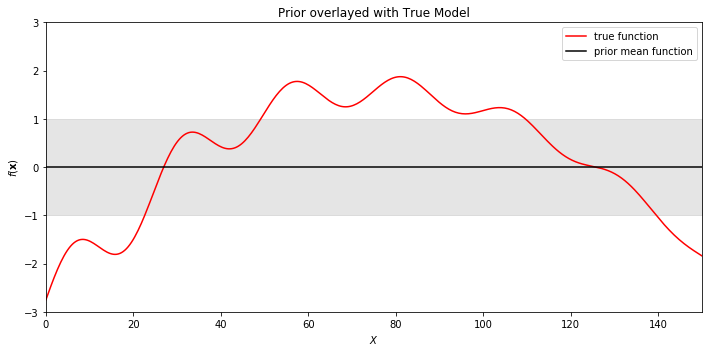

In [6]:
#Make figure canvas
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(111)

#Visualize the true model
ax.plot(x,y,'r', label='true function')

#Visualize the GP prior with 95% confidence zone

#Mean function
ax.plot(x,m_x,'k',label='prior mean function')

#95% confidence interval (approx 2 stds)
plt.fill_between(x[:,0],m_x[:,0] - np.sqrt(K.diagonal()), m_x[:,0] + np.sqrt(K.diagonal()),color='grey', alpha=0.2)

#Set figure properties
ax.set_xlabel(r'$X$')
ax.set_ylabel(r'$f(\mathbf{x})$')
ax.set_title('Prior overlayed with True Model')
ax.set_xlim(left=0,right=150)
ax.set_ylim(bottom=-3,top=3)
plt.tight_layout()
plt.legend()
plt.savefig('./figures/prior_with_model.png')
plt.show()

***
Since $\mathcal{GP}$ is a *distribution of functions* with some intrinsic covariance structure, we can sample the **prior function** as we would for any probability distribution. 

**TODO** Implement function sampling of $\mathcal{GP}$


***

Now that we've specified our **prior function model**, the next step is to fit our model to an observation we may make. In ML-speak this is the training data, in Bayesian-speak these are observations/evidence that we must integrate into our prior model. 

Suppose we make a few observations of our data, we can integrate this evidence into our prior using Bayes theorem to compute a **predictive posterior distribution**. This deviates a little bit from traditional Bayesian estimation  where you can iteratively update your prior, in this case you need to re-fit your entire dataset for each new sample point. (Although modern methods exist to iteratively do this using some computational tricks)

We'll first pick a set of samples at random and denote these $X \in \mathcal{X}$ for the input points we sample and $\mathbf{f}$ for the outputs. This will be used to fit our $\mathcal{GP}$ regression model. 

In [7]:
#Pick training data to fit regressor on
n_samps = 5
X = np.random.uniform(0,150,size=(n_samps,1))
f = true_func(X).reshape((n_samps,1))

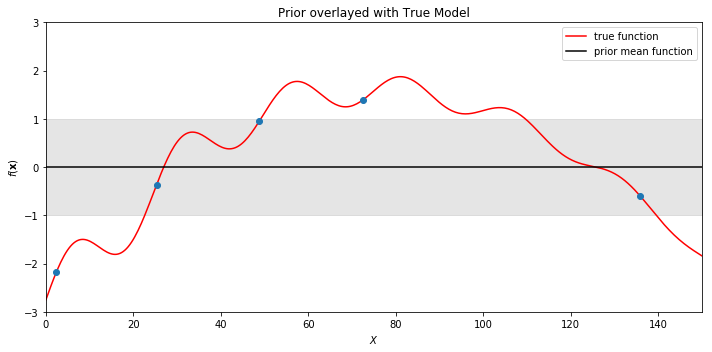

In [11]:
#Make figure canvas
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(111)

#Visualize the true model
ax.plot(x,y,'r', label='true function')

#Visualize the GP prior with 95% confidence zone

#Mean function of prior
ax.plot(x,m_x,'k',label='prior mean function')
ax.plot(X,f,'o')

#95% confidence interval (Z distribution) using diagonal of prior covariance function
plt.fill_between(x[:,0],m_x[:,0] - np.sqrt(K.diagonal()), m_x[:,0] + np.sqrt(K.diagonal()),color='grey', alpha=0.2)

#Set figure properties
ax.set_xlabel(r'$X$')
ax.set_ylabel(r'$f(\mathbf{x})$')
ax.set_title('Prior overlayed with True Model')
ax.set_xlim(left=0,right=150)
ax.set_ylim(bottom=-3,top=3)
plt.tight_layout()
plt.legend()

plt.savefig('./figures/sample_point.png')
plt.show()

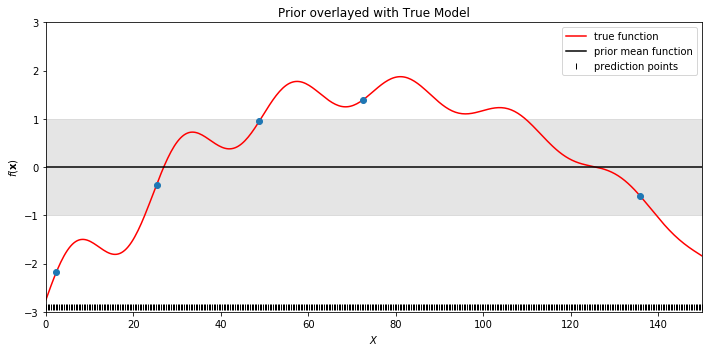

In [16]:
#Make figure canvas
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(111)

#Visualize the true model
ax.plot(x,y,'r', label='true function')

#Visualize the GP prior with 95% confidence zone

#Plot prior
ax.plot(x,m_x,'k',label='prior mean function')

#Mean function of sample points
ax.plot(x,m_x-2.9,'k|',label='prediction points')
ax.plot(X,f,'o')

#95% confidence interval (Z distribution) using diagonal of prior covariance function
plt.fill_between(x[:,0],m_x[:,0] - np.sqrt(K.diagonal()), m_x[:,0] + np.sqrt(K.diagonal()),color='grey', alpha=0.2)

#Set figure properties
ax.set_xlabel(r'$X$')
ax.set_ylabel(r'$f(\mathbf{x})$')
ax.set_title('Prior overlayed with True Model')
ax.set_xlim(left=0,right=150)
ax.set_ylim(bottom=-3,top=3)
plt.tight_layout()
plt.legend()

plt.savefig('./figures/test_points.png')
plt.show()

### The predictive distribution

Given a new sample and our current prior, we can calculate the *joint distribution* which is simply the prior distribution (a multivariate gaussian we defined earlier) multiplied by our likelihood function (our observation conditioned on the training data):

$$P(\mathbf{f},\mathbf{f_*},X_*,X) = P( \mathbf{f_*},X_* | X,\mathbf{f})P(\mathbf{f} | X)$$

The *joint distribution* is *also a gaussian distribution* in the form of:

$$
\left[\begin{matrix} 
\mathbf{f} \\
\mathbf{f_*}
\end{matrix}\right] = 
\mathcal{N}\left(\mathbf{0}, 
\left[\begin{matrix}
K(X,\mathbf{x}_*) & K(X,\mathbf{x}_*) \\
K(\mathbf{x}_*,X) & K(\mathbf{x}_*,\mathbf{x}_*)
\end{matrix}\right]\right)
$$

Where $X$ is the prior distribution samples we generated, $\mathbf{x}_*$ is value at which we sampled $\mathcal{X}$. 
Therefore:
- $K(X,X) \in \mathbb{R}^{N, N}$ is the covariance function between all prior distrbution points (we have this)
- $K(X,\mathbf{x}_*) \in \mathbb{R}^{N, M}$ is the covariance function between the prior distribution points and the new sample
- $K(\mathbf{x}_*,X) \in \mathbb{R}^{M,N} = K(X,\mathbf{x}_*)^T$
- $K(\mathbf{x}_*,\mathbf{x}_*) \in \mathbb{R}^{M,M}$ is the covariance function between all new incoming points

The joint covariance matrix is $\Sigma \in \mathbb{R}^{M+N,M+N}$ 
***
**NOTE**: We could've sampled multiple new values to generate $X_*$, the computation will be exactly the same except we'd use the matrix form rather than a single vector $\mathbf{x}_*$. Hereafter we'll just call $\mathbf{x}_*$, $X_*$ for generalizability.
***

Finally, we need to compute the **posterior distribution** which requires us to divide the joint distribution by the **marginal** which is expressed as the following:

$$P(X_*,\mathbf{f_*} | X) = \int P(\mathbf{f_*},X_* | X,\mathbf{f})P(\mathbf{f}|X)d\mathbf{f}$$

Conveniently, it turns out the **posterior distribution**, $\mathbf{f} | X,X_*,\mathbf{f_*}$, is *also a gaussian distribution* (gaussian $\mathbf{f}$ conditioned on gaussian $(X,X_*,\mathbf{f_*})$ is gaussian!) of form:

$$\mathbf{f} | X,X_*,\mathbf{f_*} \sim 
\mathcal{N}(m(\mathbf{x}) + K(X,X_*)K(X_*,X_*)^{-1}\mathbf{f_*},
K(X,X) - K(X,X_*)K(X_*,X_*)^{-1}K(X_*,X))$$


The derivation of the above result is a well known exercise in bayesian statistics, numerous proofs are available all over the internet. It is *long and painful*, but it is entirely doable!
***

Anyhow, let's implement this in practice. Recall we have:
1. a prior distribution $\mathbf{f}$ specified by our **mean function** and **covariance function**
2. A new observation of the form $(X_*,\mathbf{f_*})$

Our goal now is to compute our posterior distribution using the above information. To achieve this, we will implement a small variation on $\text{Algorithm } 2.1$ by Rasmussen & Williams$^1$ (2006) below:

***

$^1 \text{ Algorithm } 2.1$ computes the *predictive distribution* which is $\mathbf{f}_* | \mathbf{f},X,X_*$, we want to compute the *posterior distribution* which is slightly different: $\mathbf{f} | X,X_*,\mathbf{f_*}$
***

First we compute the **posterior mean function** $\bar{\mathbf{f}}$:

$$\bar{\mathbf{f}} = m(\mathbf{x}) + K(X,X_*)K(X_*,X_*)^{-1}\mathbf{f}_*$$

Here's a helpful set of equations to explain the dimensionality of the input data:
$$\mathbb{R}^{N,1} = \mathbb{R}^{N,1} + \mathbb{R}^{N,M}\left[\mathbb{R}^{M,M}\mathbb{R}^{M,1}\right]$$
$$ = \mathbb{R}^{N,1} + \left[\mathbb{R}^{N,M}\mathbb{R}^{M,1}\right]$$
$$ = \mathbb{R}^{N,1} + \mathbb{R}^{N,1}$$

In [17]:
#samp_x is the 3 training points
#samp_fx is the evaluated points 
l = 0.01

In [18]:
def sq_exp_dist(a,b,l=0.1):
    dist = np.sum(a**2,1).reshape(-1,1) + np.sum(b**2,axis=1) - 2*np.dot(a,b.T)
    return np.exp(-0.5*l * dist)

In [20]:
#Compute training covariance function
K = sq_exp_dist(X,X,l)

#Cholesky decomposition of K with added noise
L = np.linalg.cholesky(K + 0.0001*np.eye(K.shape[0]))

In [21]:
#Compute prior/observation covariance structure
K_x_xs = sq_exp_dist(X,x,l)
K_xs_x = K_x_xs.T
K_xs_xs = sq_exp_dist(x,x,l)

In [22]:
#Compute the mean using solutions to linear systems 
#alpha = inv(L)f
alpha = np.linalg.solve(L,f)

#beta = inv(L)(K_x_xs)
beta = np.linalg.solve(L,K_x_xs)

#Predicted mean
pred_mu = beta.T @ alpha

The next step is to compute the **posterior covariance function**. Note that this is given by:

$$\mathbb{V}[\mathbf{f}] = K(X,X) - K(X,X_*)K(X_*,X_*)^{-1}K(X_*,X)$$

Again, we'll show the dimensionality equations:

$$\mathbb{R}^{N,N} = \mathbb{R}^{N,N} - \mathbb{R}^{N,M}\left[\mathbb{R}^{M,M}\mathbb{R}^{M,N}\right]$$
$$ = \mathbb{R}^{N,N} - \left[\mathbb{R}^{N,M}\mathbb{R}^{M,N}\right]$$
$$ = \mathbb{R}^{N,N} - \mathbb{R}^{N,N} $$

In [23]:
pred_var = K_xs_xs - beta.T @ beta
pred_std = pred_var.diagonal()

Let's visualize how our estimate of the true underlying distribution changes when we observe a sample!

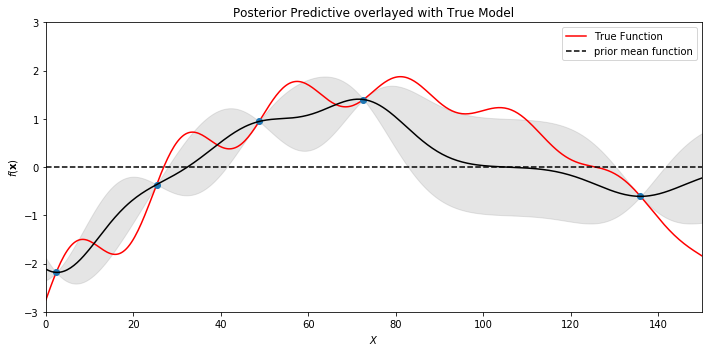

In [26]:
#Visualize the predictive distribution
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(111)

ax.plot(x,y,'r',label='True Function')

#Visualize the GP prior with 95% confidence zone
ax.plot(x,m_x,'k--',label='prior mean function')
ax.plot(X,f,'o')

#Plot posterior predictive function
ax.plot(x,pred_mu,'k')
plt.fill_between(x[:,0],pred_mu[:,0] - np.sqrt(pred_var.diagonal()),
                 pred_mu[:,0] + np.sqrt(pred_var.diagonal()),color='grey', 
                 alpha=0.2)

#Set figure properties
ax.set_xlabel(r'$X$')
ax.set_ylabel(r'$f(\mathbf{x})$')
ax.set_title('Posterior Predictive overlayed with True Model')
ax.set_xlim(left=0,right=150)
ax.set_ylim(bottom=-3,top=3)
plt.tight_layout()
plt.legend()

plt.savefig('./figures/posterior_model.png')
plt.show()

The beautiful thing about bayesian statistics is that our *posterior distribution becomes the prior* for our next iteration. In fact we can keep iterating and over time we'll be able to pretty accurately approximate the underlying distribution confidently. Below, we wrap everything we did earlier in convenient functions in order to visualize the entire iterative sampling process

In [39]:
def true_func(x):
    return 0.1*((8*np.exp(-0.0125*x))*np.sin(x*0.25) + 0.055*x + 50*np.exp(-10/(1+0.25*x)) -
                0.005*(x-50)**2)  - 1.5

In [40]:
def sq_exp_dist(a,b,l=0.1):
    dist = np.sum(a**2,1).reshape(-1,1) + np.sum(b**2,axis=1) - 2*np.dot(a,b.T)
    return np.exp(-0.5*l * dist)

In [100]:
def pick_sample(x):
    '''
    Draw a sample from the input domain x
    '''
    
    x_samp = np.random.uniform(0,np.max(x))
    f_samp = true_func(x_samp)
    return x_samp, f_samp

In [134]:
def compute_posterior(x,x_s,f,l):
    '''
    Compute posterior distribution 
    x   -- prior points (training) to condition on [N,1]
    x_s -- prediction points [M,1]
    f   -- objective function evaluated on x
    l   -- characteristic length scale hyperparameter
    '''
    
    #Compute joint covariance matrix components
    K = sq_exp_dist(x,x,l)
    K_x_xs = sq_exp_dist(x,x_s,l)
    K_xs_x = K_x_xs.T
    K_xs_xs = sq_exp_dist(x_s,x_s,l)
    
    
    #Cholesky decomposition of prior covariance with added noise for numerical stability
    L = np.linalg.cholesky(K + 0.0001*np.eye(K.shape[0]))
    alpha = np.linalg.solve(L,f)
    beta = np.linalg.solve(L,K_x_xs)
    
    #Compute predictive distribution
    mu_f = beta.T @ alpha
    var_f = K_xs_xs - beta.T @ beta

    
    return mu_f, var_f

In [135]:
def visualize_gp(ax,x,f,K):
    '''
    Plot gaussian process using 2*std as uncertainty patch
    '''
    
    #Clear axes
    ax.clear() 
    
    #Plot mean func
    ax.plot(x,f,'k')
    
    #Plot uncertainty estimate
    ax.fill_between(x[:,0],f[:,0] - 2*K.diagonal(), f[:,0] + 2*K.diagonal(), color='grey', alpha=0.2)
    
    return ax
    

In [142]:
#Starting from scratch, define the test points we'll use to visualize our gaussian process and evaluate
num_x = 400
x_s = np.linspace(0,150,num_x).reshape((num_x,1))
l = 0.01

#The number of iterations of fitting we'll perform
n_iter = 10

#Prior for visualization

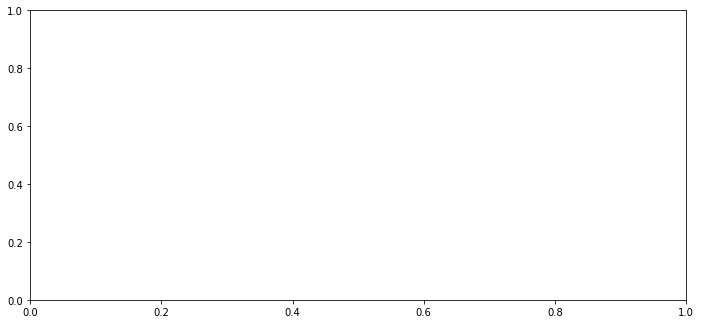

In [144]:
#Set up base figure properties
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(111)

#Keep track of which x we've already sampled for two reasons:
#1 : Since we're dealing with noise-less case, there's no point of sampling the same point twice

#2 : With the noise-less case the variance of the sampled point is 0. 
#    thus computing the posterior variance which requires inversion of K_xs_xs will fail spectacularly
#    so you couldn't do it anyway..
sampled_x = []
sampled_f = []

#Pick our initial sample
x_samp, f_samp = pick_sample(x)

#Iterate n_iter times
for i in np.arange(0,n_iter):
    
    #Ensure point hasn't already been sampled
    while x_samp in sampled_x:
        x_samp, f_samp = pick_sample(x)

    #Add to list of already sampled values
    sampled_x.append(x_samp)
    sampled_f.append(f_samp)
    
    #Accumulate training data
    X = np.array(sampled_x).reshape(len(sampled_x),1)
    f = np.array(sampled_f).reshape(len(sampled_f),1)
    
    #Compute posterior
    mu_f, var_f = compute_posterior(X,x_s,f,l)
    
    #Plot true function
    ax.plot(x,y,'r',label='True Function')

    #Visualize observation
    ax.plot(X,f,'o', label='sample point')
    
    #Visualize estimation
    ax.plot(x,mu_f,'k', label = 'prediction mean')
    plt.fill_between(x[:,0],mu_f[:,0] - np.sqrt(var_f.diagonal()),
                     mu_f[:,0] + np.sqrt(var_f.diagonal()),color='grey', 
                     alpha=0.2)

    #Set figure properties
    ax.set_xlabel(r'$X$')
    ax.set_ylabel(r'$f(\mathbf{x})$')
    ax.set_title('Posterior Predictive overlayed with True Model')
    ax.set_xlim(left=0,right=150)
    ax.set_ylim(bottom=-3,top=3)
    plt.tight_layout()
    plt.legend()
    
    plt.savefig('./figures/iteration_{}.png'.format(i))
    ax.clear()
    